Pipeline 1: Thu thập Dữ liệu và Tiền xử lý ban đầu

In [2]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc  # For garbage collection

# Force garbage collection
gc.collect()

0

In [3]:
import os
import pathlib
import pandas as pd  # Make sure you import pandas

print("Current working directory:", os.getcwd())
print(pathlib.Path("data/processed/cv/processed_results.json").resolve())

try:
    # Read CV data from the JSON file
    df = pd.read_json(r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv\processed_results.json")
    
    print("Data loaded successfully")
    print("Number of documents:", len(df))
    
    # Initialize tokenizer
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    
    tokenizer = Tokenizer(num_words=5000)
    
    # Fit tokenizer on texts
    texts = df['text'].values  # Assuming 'text' is the column containing the extracted text
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences
    maxlen = 100
    X = pad_sequences(sequences, maxlen=maxlen)
    
    print("Data preprocessing completed")
    print("Input shape:", X.shape)

except Exception as e:
    print(f"Error during data preparation: {str(e)}")


Current working directory: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\backend\src\models
C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\backend\src\models\data\processed\cv\processed_results.json
Data loaded successfully
Number of documents: 459
Data preprocessing completed
Input shape: (459, 100)


Pipeline 2: Xây dụng và huấn luyện mô hình

In [4]:
# Cell 3: Define model
try:
    # Model parameters
        vocab_size = min(5000, len(tokenizer.word_index) + 1)
        embedding_dim = 100
        
        # Build model
        model = Sequential([
            Embedding(vocab_size, embedding_dim),
            Bidirectional(LSTM(64, return_sequences=True)),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(32)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(embedding_dim, activation='tanh')
        ])
        
    # Compile model
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['cosine_similarity']
        )
        
        print(model.summary())
        
except Exception as e:
    print(f"Error building model: {str(e)}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Cell 4: Train model
try:
    # Define callbacks
        callbacks = [
            ReduceLROnPlateau(
                monitor='loss',
                factor=0.2,
                patience=2,
                min_lr=1e-5
            ),
            EarlyStopping(
                monitor='loss',
                patience=5,
                restore_best_weights=True
            )
        ]
        
    # Train model
        history = model.fit(
            X, X,  # Autoencoder style training
            validation_split=0.2,
            epochs=10,  # Reduced epochs
            batch_size=16,  # Reduced batch size
            callbacks=callbacks
        )
        
        print("Training completed successfully")
        
except Exception as e:
    print(f"Error during training: {str(e)}")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 412ms/step - cosine_similarity: 0.0510 - loss: 1457532.2500 - val_cosine_similarity: 0.4823 - val_loss: 1527162.1250 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - cosine_similarity: 0.3600 - loss: 1418117.6250 - val_cosine_similarity: 0.5166 - val_loss: 1527027.5000 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - cosine_similarity: 0.4990 - loss: 1414985.2500 - val_cosine_similarity: 0.5441 - val_loss: 1526825.0000 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - cosine_similarity: 0.5469 - loss: 1428789.8750 - val_cosine_similarity: 0.5623 - val_loss: 1526651.8750 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - cosine_similarity: 0.5627 - loss: 1438212.6250 - val_cosine_similarity: 0.5697 - val_loss: 1526430.7500 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - cosine_similarity: 0.5685 - loss

In [6]:
# Cell 5: Save model and tokenizer
import os
print(os.listdir(r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv"))
try:
    import json
    import os

    # Create directories if they don't exist
    os.makedirs('data/processed/cv', exist_ok=True)
        
    # Save model
    model.save('data/processed/cv/model.h5')
        
    # Save tokenizer
    tokenizer_json = tokenizer.to_json()
    with open('data/processed/cv/tokenizer.json', 'w') as f:
        json.dump(tokenizer_json, f)
        
    print("Model and tokenizer saved successfully")

except Exception as e:
    print(f"Error saving model and tokenizer: {str(e)}")


['cv_texts.csv', 'processed_results.json']
Model and tokenizer saved successfully


In [8]:
# Cell 6A: Import and define matching function
import numpy as np

def calculate_cv_match(cv_text, job_description, model, tokenizer):
    """
    Calculate matching score between a CV and job description
    """
    try:
        # Preprocess texts
        cv_seq = tokenizer.texts_to_sequences([cv_text])
        jd_seq = tokenizer.texts_to_sequences([job_description])
        
        # Pad sequences
        maxlen = 100
        cv_pad = pad_sequences(cv_seq, maxlen=maxlen)
        jd_pad = pad_sequences(jd_seq, maxlen=maxlen)
        
        # Get embeddings
        cv_embedding = model.predict(cv_pad, verbose=0)
        jd_embedding = model.predict(jd_pad, verbose=0)
        
        # Calculate cosine similarity
        similarity = np.dot(cv_embedding[0], jd_embedding[0]) / (
            np.linalg.norm(cv_embedding[0]) * np.linalg.norm(jd_embedding[0])
        )
        
        return float(similarity * 100)  # Convert to percentage
        
    except Exception as e:
        print(f"Error calculating match: {str(e)}")
        return 0.0

In [9]:
# Cell 6B: Define example job description
job_description = """
We are looking for a Python Developer with:
- Strong experience in Python programming
- Knowledge of machine learning and data analysis
- Experience with web frameworks like Django or Flask
- Database experience (SQL, MongoDB)
- Good understanding of software development principles

Requirements:
- Bachelor's degree in Computer Science or related field
- 3+ years of professional Python development experience
- Experience with cloud platforms (AWS/Azure)
"""

print("Job Description loaded")

Job Description loaded


In [11]:
# Cell 6C: Process CVs and calculate matches
try:
    # Read CV data
    cv_df = pd.read_json(
        r"C:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv\processed_results.json"
    )
    print(f"Loaded {len(cv_df)} CVs")
    
    # Calculate matches
    results = []
    for index, row in cv_df.iterrows():
        # Use 'text' instead of 'content'
        score = calculate_cv_match(row['text'], job_description, model, tokenizer)
        results.append({
            'filename': row['filename'],
            'match_score': score
        })
        print(f"Processed CV {index + 1}/{len(cv_df)}", end='\r')
    
    print("\nCV processing completed")
    
except Exception as e:
    print(f"Error processing CVs: {str(e)}")


Loaded 459 CVs
Processed CV 459/459
CV processing completed


In [12]:
# Cell 6D: Create and display results
try:
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by match score
    results_df = results_df.sort_values('match_score', ascending=False)
    
    # Display top matches
    print("\nTop CV Matches:")
    print("-" * 50)
    print(results_df.to_string(index=False))
    
    # Save results
    output_path = 'data/processed/cv/matching_results.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
    
except Exception as e:
    print(f"Error handling results: {str(e)}")


Top CV Matches:
--------------------------------------------------
                                           filename  match_score
                                       74522938.pdf    99.977911
                                       17396388.pdf    99.975854
                                       28092317.pdf    99.973959
                                       98348532.pdf    99.969673
                                       20149476.pdf    99.968028
                                       32518109.pdf    99.967402
                                       92122785.pdf    99.967343
                                       14879257.pdf    99.966651
                                       24799301.pdf    99.966198
                                       62555739.pdf    99.965888
                                       83206166.pdf    99.965817
                                       36379931.pdf    99.964142
                                       80053367.pdf    99.964023
                      

In [21]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

# Model parameters
vocab_size = min(5000, len(tokenizer.word_index) + 1)
embedding_dim = 100

# Build model
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Dropout(0.4),  # Increase dropout
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Dropout(0.4),  # Increase dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(embedding_dim, activation='tanh')
])

# Compile model with additional metrics
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        'cosine_similarity',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Add learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Increase epochs with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X, X,
    validation_split=0.2,
    epochs=20,  # Increase epochs
    batch_size=16,
    callbacks=[reduce_lr, early_stopping]
)



Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 416ms/step - cosine_similarity: 0.0686 - loss: 1398737.0000 - precision: 1.0000 - recall: 0.2496 - val_cosine_similarity: 0.4934 - val_loss: 1527170.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - cosine_similarity: 0.3520 - loss: 1444293.2500 - precision: 1.0000 - recall: 0.4756 - val_cosine_similarity: 0.5180 - val_loss: 1527024.1250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - cosine_similarity: 0.4903 - loss: 1429817.8750 - precision: 1.0000 - recall: 0.7016 - val_cosine_similarity: 0.5461 - val_loss: 1526827.8750 - val_precision: 1.0000 - val_recall: 0.0172 - learning_rate: 0.0010
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - cosine_similarity: 0.5471 - loss: 1433032.7500 - precision: 1.0000 - recall: 0.8571 - val_cosine_similarity: 0.5634 - val_loss: 1526623.0

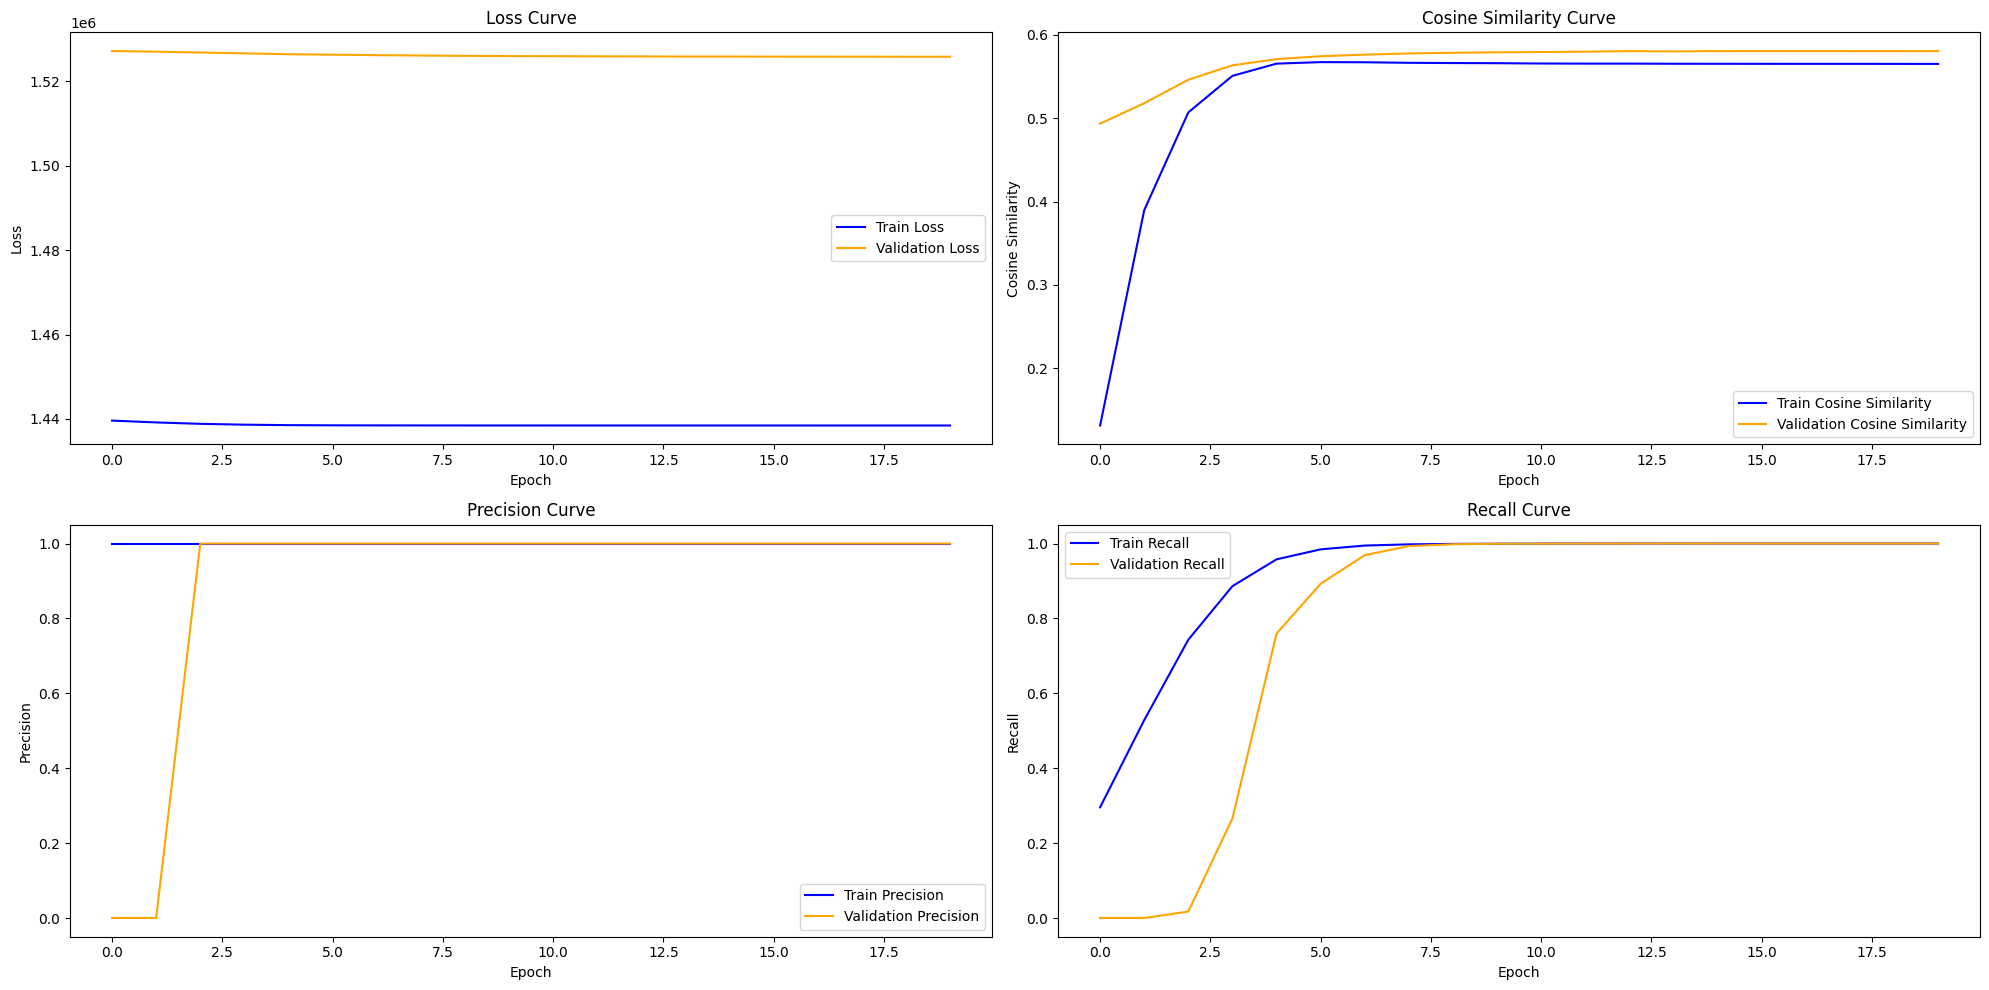


Final Metrics:
Loss: 1438438.0000
Validation Loss: 1525827.5000
Cosine Similarity: 0.5651
Validation Cosine Similarity: 0.5805
Precision: 1.0000
Validation Precision: 1.0000
Recall: 1.0000
Validation Recall: 1.0000


In [22]:
# Visualize results with updated metrics
import matplotlib.pyplot as plt

# Create figure with multiple subplots
plt.figure(figsize=(20, 10))

# Plot Loss Curve
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Cosine Similarity Curve
plt.subplot(2, 2, 2)
plt.plot(history.history['cosine_similarity'], label='Train Cosine Similarity', color='blue')
plt.plot(history.history['val_cosine_similarity'], label='Validation Cosine Similarity', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Curve')
plt.legend()

# Plot Precision Curve
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision', color='blue')
plt.plot(history.history['val_precision'], label='Validation Precision', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()

# Plot Recall Curve
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall', color='blue')
plt.plot(history.history['val_recall'], label='Validation Recall', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
print(f"Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Cosine Similarity: {history.history['cosine_similarity'][-1]:.4f}")
print(f"Validation Cosine Similarity: {history.history['val_cosine_similarity'][-1]:.4f}")
print(f"Precision: {history.history['precision'][-1]:.4f}")
print(f"Validation Precision: {history.history['val_precision'][-1]:.4f}")
print(f"Recall: {history.history['recall'][-1]:.4f}")
print(f"Validation Recall: {history.history['val_recall'][-1]:.4f}")

In [ ]:
# Pipeline 3: Course Recommendation System

# First, let's create our CourseRecommender class
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class CourseRecommender:
    def __init__(self):
        # Initialize course database with sample data
        self.courses_df = pd.DataFrame({
            'course_name': [
                'Python Programming Fundamentals',
                'Machine Learning Basics',
                'Web Development with JavaScript',
                'Data Analysis with Python',
                'Deep Learning Specialization',
                'Software Engineering Principles',
                'Database Management Systems',
                'Cloud Computing Fundamentals',
                'Artificial Intelligence Basics',
                'Data Structures and Algorithms'
            ],
            'skills': [
                'python programming basics algorithms',
                'machine learning python statistics data science',
                'javascript html css web development frontend',
                'python pandas numpy data analysis visualization',
                'deep learning neural networks AI tensorflow pytorch',
                'software engineering design patterns testing agile',
                'sql database management mysql postgresql',
                '